## Stage 02: Volatility Calculation
Compute the realized volatility from the historical summary and forward-looking volatility using GARCH(1,1).

In [12]:
# project path
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().parent
SRC_PATH = PROJECT_ROOT / "src"

if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))


### Load Stock Data

In [18]:
from pathlib import Path
import pandas as pd
from options_valuation.config import data_dir

def load_latest_price_data():
    raw_dir = Path(data_dir()) / "raw"
    files = sorted(
        raw_dir.glob("*_daily_*.csv"),
        key=lambda p: p.stat().st_mtime,
        reverse=True,
    )

    if not files:
        raise FileNotFoundError("No price data found in data/raw.")

    latest = files[0]
    ticker = latest.name.split("_")[0]

    df = pd.read_csv(latest)
    return ticker, df

ticker, df = load_latest_price_data()
print("Loaded ticker:", ticker)

# Basic Sanity Checks
print(df.columns)
print(df.dtypes)
print("Rows:", len(df))
print("Date range:", df["date"].min(), "->", df["date"].max())


Loaded ticker: AAPL
Index(['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume'], dtype='object')
date          object
open         float64
high         float64
low          float64
close        float64
adj_close    float64
volume         int64
dtype: object
Rows: 501
Date range: 2024-01-08 -> 2026-01-06


### Compute Daily Log Return

In [34]:
import numpy as np
# Use adjusted close if available
price_col = "adj_close" if "adj_close" in df.columns else "close"
print("Using price column:", price_col)

# Compute daily log return
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

df["log_return"] = np.log(df[price_col] / df[price_col].shift(1))
df = df.dropna().reset_index(drop=True)

display(df[["date", price_col, "log_return"]].head())

# Basic statistics
print("Mean log return:", df["log_return"].mean())
print("Std log return (daily):", df["log_return"].std())

Using price column: adj_close


,date,adj_close,log_return
0,2024-01-16,181.912033,-0.012394
1,2024-01-17,180.970917,-0.005187
2,2024-01-18,186.865280,0.032052
3,2024-01-19,189.767838,0.015413
4,2024-01-22,192.076035,0.012090


Mean log return: 0.0007133079358563435
Std log return (daily): 0.017512455537616656


### Save the Daily Log Return
Save the daily log return in data/processed/ folder

In [44]:
from pathlib import Path
from options_valuation.config import data_dir

processed_dir = Path(data_dir()) / "processed"
processed_dir.mkdir(parents=True, exist_ok=True)

out_path = processed_dir / f"{ticker}_log_return_daily.csv"

df[["date", price_col, "log_return"]].to_csv(out_path, index=False)

print("Saved log returns to:", out_path)

Saved log returns to: /Users/allenpilipala/BSM_model/data/processed/AAPL_log_return_daily.csv


### Plot the Daily Log Return over 2 years
Plot the log return and save it to the docs/ folder

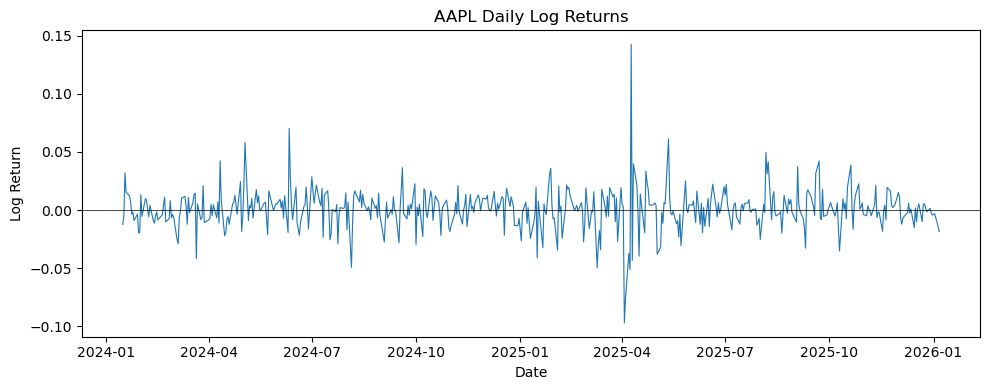

Log return plot saved to: /Users/allenpilipala/BSM_model/docs/AAPL_daily_log_return.png


In [51]:
import matplotlib.pyplot as plt
from pathlib import Path
from options_valuation.config import data_dir

# Prepare output directory
docs_dir = Path(data_dir()).parent / "docs"
docs_dir.mkdir(parents=True, exist_ok=True)

# Plot log returns
plt.figure(figsize=(10, 4))
plt.plot(df["date"], df["log_return"], linewidth=0.8)
plt.axhline(0, color="black", linewidth=0.5)
plt.title(f"{ticker} Daily Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.tight_layout()
plt.show()

# Save figure
out_path = docs_dir / f"{ticker}_daily_log_return.png"
plt.savefig(out_path, dpi=300)
plt.close()

print("Log return plot saved to:", out_path)
